In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras import regularizers

In [2]:
# Set Random Seed and Plot Parameters
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)


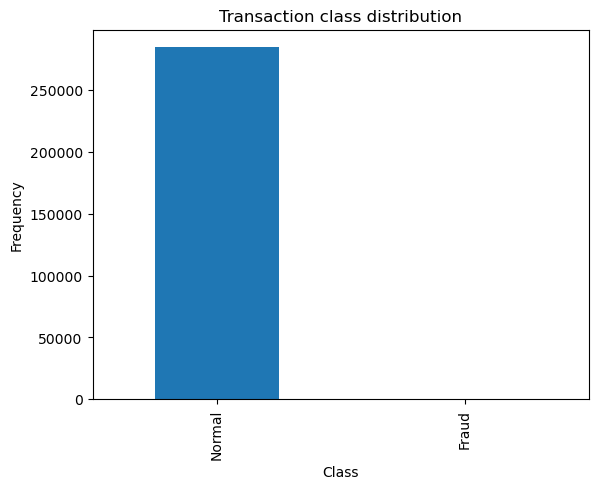

In [3]:
# Load and Preprocess the Dataset
df = pd.read_csv(r"C:\Users\ASUS\Downloads\creditcard.csv")
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar')
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");



In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
data = df.drop(['Time'], axis=1)


In [5]:
# Train-Test Split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0].drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [6]:
# Define Autoencoder Architecture
input_dim = X_train.shape[1]
encoding_dim = 14

In [7]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = Dense(encoding_dim // 2, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)



In [8]:
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.6967 - val_loss: 0.7346
Epoch 2/100
7108/7108 [==============================] - 25s 4ms/step - loss: 0.6970 - val_loss: 0.7337
Epoch 3/100
7108/7108 [==============================] - 34s 5ms/step - loss: 0.6971 - val_loss: 0.7314
Epoch 4/100
7108/7108 [==============================] - 31s 4ms/step - loss: 0.6970 - val_loss: 0.7326
Epoch 5/100
7108/7108 [==============================] - 25s 4ms/step - loss: 0.6970 - val_loss: 0.7341
Epoch 6/100
7108/7108 [==============================] - 26s 4ms/step - loss: 0.6967 - val_loss: 0.7331
Epoch 7/100
7108/7108 [==============================] - 25s 4ms/step - loss: 0.6968 - val_loss: 0.7336
Epoch 8/100
7108/7108 [==============================] - 26s 4ms/step - loss: 0.6967 - val_loss: 0.7331
Epoch 9/100
7108/7108 [==============================] - 25s 4ms/step - loss: 0.6967 - val_loss: 0.7326
Epoch 10/100
7108/7108 [==============================] - 25s 4m

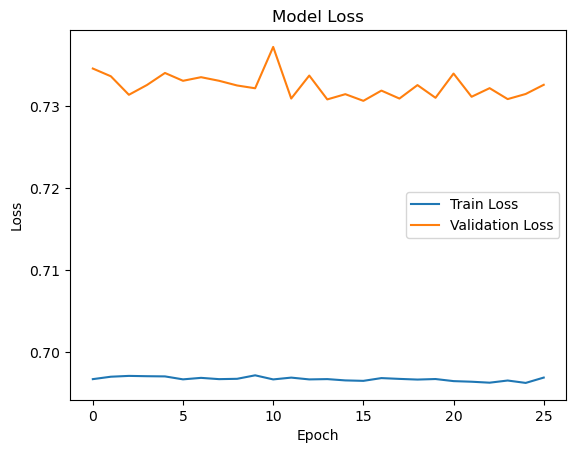

In [12]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Evaluate on Test Data
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

1781/1781 [==============================] - 2s 1ms/step


In [14]:
# Set Threshold and Plot Reconstruction Error
threshold = 50  # Arbitrary; adjust based on analysis
error_df['pred'] = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]



In [15]:
error_df.describe()

,reconstruction_error,true_class,pred
count,56962.000000,56962.000000,56962.000000
mean,0.729688,0.001720,0.000808
std,3.414177,0.041443,0.028406
min,0.066107,0.000000,0.000000
25%,0.234932,0.000000,0.000000
50%,0.378518,0.000000,0.000000
75%,0.613981,0.000000,0.000000
max,254.611528,1.000000,1.000000


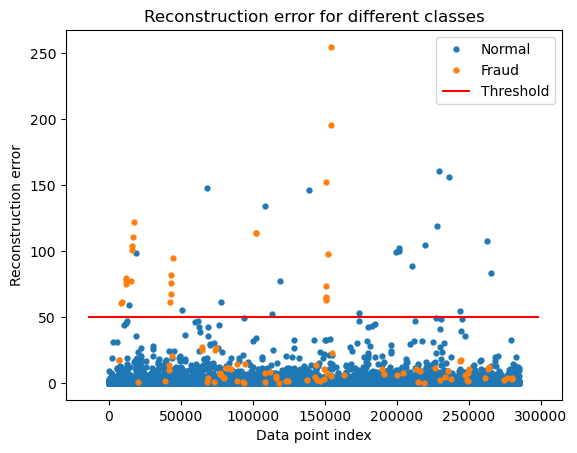

In [16]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

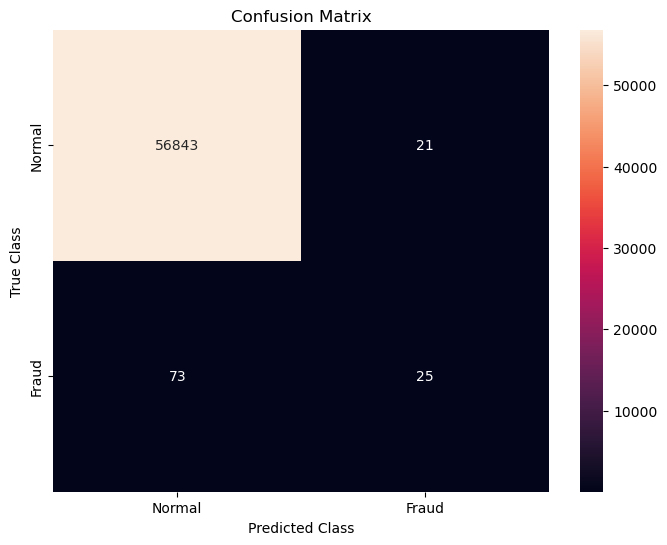

In [17]:
# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(error_df['true_class'], error_df['pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [18]:
# Print Performance Metrics
print(f"Accuracy: {accuracy_score(error_df['true_class'], error_df['pred']):.4f}")
print(f"Recall: {recall_score(error_df['true_class'], error_df['pred']):.4f}")
print(f"Precision: {precision_score(error_df['true_class'], error_df['pred']):.4f}")

Accuracy: 0.9983
Recall: 0.2551
Precision: 0.5435
